# Загрузка и установка необходимых библиотек

In [ ]:
! pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 4.6 MB/s 
     |████████████████████████████████| 240 kB 71.7 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=74f9164c857eb79ad6726ac53a556c7735a11868c2197a9b67a891fd2b52ec87
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
! pip install dostoevsky

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.7 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=3128297 sha256=facb3d8354bf2c9640a2e235379638322a16869a452df0ad631a5c5af71ca3c0
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [ ]:
import pandas as pd
import stanza
stanza.download('ru')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from tqdm import tqdm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim.downloader
import re
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

INFO:stanza:Downloading default packages for language: ru (Russian) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_asp = pd.read_csv(
    'train_split_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_split_reviews.txt', delimiter='\t', names=['text_id','text'])

Чтобы узнать объём тренировочной выборки:

In [ ]:
nlp = stanza.Pipeline('ru', processors='tokenize,lemma', use_gpu = True)

def tokenize(text):
    doc = nlp(text)
    words = []
    for sent in doc.sentences:
        for word in sent.words:
            words.append(word.lemma)
    return words

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| lemma     | syntagrus |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
tokenized_train = []
texts = train_texts.text
for text in texts:
    tokenized_train.extend(tokenize(text))
len(tokenized_train)

34848

In [ ]:
dev_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id', 'text'])

# Расширение списка лемм-упоминаний

## Констрастивный метод

Сравнение корпуса отзывов с нейтральным корпусом:

In [ ]:
news = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
news_texts = news.text[:7000]  # значительно сократим выборку, так как stanza очень долго работает даже на GPU
# кроме того, выборка с отзывами тоже достаточно небольшая, 
# так что сокращение количества новостных текстов кажется оправданным

Можно попробовать выделить ключевые слова для корпуса отзывов по сравнению с нейтральным корпусом. Можно предположить, что среди этих ключевых слов будут важные униграммы-упоминания.

Предобработка текстов. 

Для задачи выделения ключевых слов – аспектов – можно удалить стоп-слова и лемматизировать тексты. Но эти предобработанные тексты не стоит использовать при определении тональности аспектов: из текстов удаляются стоп-слова, но среди стоп-слов могут оказаться важные для анализа тональности лексические единицы (e.g. отрицательные частицы, отрицательные местоимения, интенсификаторы).

В текстах оставляются только существительные, прилагательные и глаголы, поскольку в train_asp среди упоминаний можно найти слова этих частей речи.

In [ ]:
stop_words = stopwords.words('russian')
nlp = stanza.Pipeline('ru', processors='tokenize,lemma,pos', use_gpu = True)

def normalize_NVA(text):
    doc = nlp(text)
    words = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.lemma not in stop_words and word.lemma not in string.punctuation and (word.pos == 'NOUN' or word.pos == 'ADJ' or word.pos == 'VERB'):
                words.append(word.lemma)
    return words

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
train_texts_norm = []
texts = train_texts.text
for text in tqdm(texts):
    train_texts_norm.extend(normalize_NVA(text))

100%|██████████| 213/213 [00:24<00:00,  8.84it/s]


Аналогично для news_texts:

In [ ]:
news_texts_norm = []
for text in tqdm(news_texts):
    news_texts_norm.extend(normalize_NVA(text))

100%|██████████| 7000/7000 [15:08<00:00,  7.70it/s]


Посчитаем метрику "странность".

Для подсчёта weirdness необходимо вычислить:

- FRC - число словоупотреблений во всей исследуемой коллекции;

- FRCC - число словоупотреблений в контрастной коллекции;

- FRL - частотность леммы в исследуемой коллекции;

- FRLC - частотность леммы в контрастной коллекции.

In [ ]:
FRC = len(train_texts_norm)
FRC

14073

In [ ]:
FRCC = len(news_texts_norm)
FRCC

635629

In [ ]:
counts_train_texts = Counter(train_texts_norm)
counts_news_texts = Counter(news_texts_norm)

In [ ]:
words_weirdness = {}
for word in counts_train_texts.keys():
    FRL = counts_train_texts[word]
    FRLC = counts_news_texts[word]
    if FRLC > 0:
        weirdness = (FRL / FRC) / (FRLC / FRCC)
        words_weirdness[word] = weirdness
    else:
        continue

In [ ]:
words_weirdness_sorted = {k: v for k, v in sorted(words_weirdness.items(), key=lambda item: item[1], reverse=True)}

Можно ограничить список слов, выбрав пороговое значение метрики.

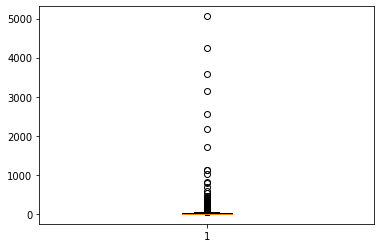

In [ ]:
x = list(words_weirdness_sorted.values())
plt.boxplot(x)
plt.show()

Можно, например, оставить в выборке только те упоминания аспектов, странность которых превышает 10.

In [ ]:
words_weirdness_filtered = {k: v for k, v in words_weirdness_sorted.items() if v > 10}

Уникальных упоминаний, собранных таким образом:

In [ ]:
new_mentions = list(words_weirdness_filtered.keys())
len(new_mentions)

666

Нормализуем упоминания в train_asp:

In [ ]:
def normalize(text):
    doc = nlp(text)
    words = [word.lemma for sent in doc.sentences for word in sent.words]
    return words

In [ ]:
train_asp['norm_mention'] = [tuple(normalize(m)) for m in train_asp['mention']]

Уникальных упоминаний в train_asp:

In [ ]:
train_mentions_unique = set(list(train_asp['norm_mention']))
len(train_mentions_unique)

1038

## Методы дистрибутивной семантики

Можно расширить список лемм также с помощью методов дистрибутивной семантики.

Загрузим модель:

In [ ]:
vectors = gensim.downloader.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


In [ ]:
train_asp_mentions = list(train_mentions_unique)

train_mentions_POS = []
for item in train_asp_mentions:
    item_formatted = '::'.join(item)
    doc = nlp(item_formatted)
    for sent in doc.sentences:
        train_mentions_POS.append(item_formatted + '_' + sent.words[-1].pos)

In [ ]:
similar_words_train = []
for mention in tqdm(train_mentions_POS):
    try:
        most_similar = vectors.most_similar(mention)
        similar_words_train.extend(most_similar)
    except:
        pass

100%|██████████| 1039/1039 [00:08<00:00, 127.06it/s]


Теперь нужно объединить similar_words_train с полученными контрастивным методом упоминаниями и вычислять для них аспекты.

Собираем всё:

- нормализованные упоминания из трейна
- similar_words_train
- собранные new_mentions

In [ ]:
new_mentions_tuple = [tuple(mention.split(';')) for mention in new_mentions]

In [ ]:
similar_words_tuple = []
for item in similar_words_train:
    item_formatted = re.sub(r'_.+', '', item[0])
    item_tuple = tuple(item_formatted.split('::'))
    similar_words_tuple.append(item_tuple)

## Итоговый список лемм

In [ ]:
all_mentions = train_asp_mentions + new_mentions_tuple + similar_words_tuple
all_mentions_unique = set(all_mentions)
len(all_mentions_unique)

3883

In [ ]:
with open('all_mentions.txt', 'w') as f:
    for l in list(all_mentions_unique):
        print(l, file=f)

# Приписывание лемме аспекта

Можно поступить следующим образом: тем упоминаниям, которые есть в train_asp, приписать аспект, уже указанный в тренировочных данных. Упоминаниям, отсутствующим в обучающей выборке, можно приписывать аспект с помощью методов дистрибутивной семантики.

In [ ]:
def get_mention_category(data, cat_type):
    mention_categories = data.value_counts(subset=['norm_mention', cat_type])
    mention_categories_dict = defaultdict(dict)
    for key, value in mention_categories.items():
        mention_categories_dict[key[0]][key[1]] = value
    return {k: Counter(v).most_common(1)[0][0] for k, v in mention_categories_dict.items()}

In [ ]:
best_mention_cat = get_mention_category(train_asp, 'category')

In [ ]:
len(best_mention_cat)  # == len(list(set(train_asp_mentions)))

1038

In [ ]:
list(pd.unique(train_asp.category))

['Whole', 'Service', 'Food', 'Interior', 'Price']

# Возвращаясь к аспектам,

In [ ]:
mentions_wo_train = all_mentions_unique.difference(set(train_asp_mentions))

In [ ]:
classes = list(pd.unique(train_asp.category))
base_words = ['ресторан_NOUN', 'обслуживание_NOUN', 'еда_NOUN', 'интерьер_NOUN', 'цена_NOUN']
base_vectors = []
for c, word in zip(classes, base_words):
    base_vectors.append(vectors[word])

In [ ]:
mentions_wo_train_POS = []
for mention in tqdm(mentions_wo_train):
    mention_formatted = '::'.join(mention)
    doc = nlp(mention_formatted)
    for sent in doc.sentences:
        mentions_wo_train_POS.append(mention_formatted + '_' + sent.words[-1].pos)

100%|██████████| 2845/2845 [01:28<00:00, 32.18it/s]


In [ ]:
all_sims = []
for k in mentions_wo_train_POS:
    try:
        sim = vectors.cosine_similarities(vectors[k], base_vectors)
        max_sim = max(sim)
        all_sims.append(max_sim)
    except KeyError:
        pass

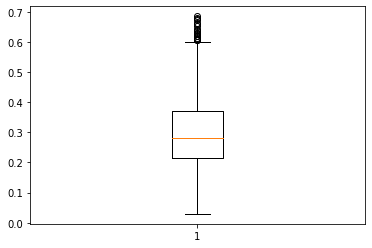

In [ ]:
plt.boxplot(all_sims)
plt.show()

In [ ]:
def get_most_similar(word):
    sim = vectors.cosine_similarities(vectors[word], base_vectors)
    if np.max(sim) <= 0.4:
        similar_class = 'Other'
    else:
        similar_class = classes[np.argmax(sim)]

    return similar_class

In [ ]:
mention_cat_wo_train = {}
for k in mentions_wo_train_POS:
    try:
        category = get_most_similar(k)
        k_formatted = re.sub(r'_.+', '', k)
        key = tuple(k_formatted.split('::'))
        mention_cat_wo_train[key] = category

    except KeyError:
        pass

In [ ]:
mention_cat_filtered = {k: v for k, v in mention_cat_wo_train.items() if v != 'Other'}

In [ ]:
len(mention_cat_filtered)

456

Нужно объединить mention_cat_filtered с best_mention_cat, потом сохранить этот дикт

In [ ]:
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z
all_mentions_categories = merge_two_dicts(mention_cat_filtered, best_mention_cat)

In [ ]:
len(all_mentions_categories)

1494

Сохранить дикт:

In [ ]:
import csv
w = csv.writer(open("all_mentions_categories.csv", "w"))

for key, val in all_mentions_categories.items():
    w.writerow([key, val])

# Анализ тональности

Анализ тональности с использованием библиотеки dostoevsky:

In [ ]:
import dostoevsky

In [ ]:
! python -m dostoevsky download fasttext-social-network-model

## 1. Тональность упоминаний, которые есть в текстах

1) Можно посчитать сначала тональность просто для каждого слова из all_mentions_categories (за исключением тех слов, для которых уже есть тональность в обучающей выборке)

2) Пройтись по текстам, если в тексте будут уни-, биграммы из списка, то нужно собрать последовательность из двух-трёх предыдущих и двух-трёх последующих токенов и посмотреть на её тональность

In [ ]:
best_mention_sentiment = get_mention_category(train_asp, 'sentiment')

In [ ]:
mentions_for_sentiment = set(list(all_mentions_categories.keys())).difference(set(list(best_mention_sentiment.keys())))

In [ ]:
len(mentions_for_sentiment)

456

In [ ]:
texts_preprocessed = []
for text in train_texts.text:
    texts_preprocessed.append(normalize(text))

In [ ]:
mentions_ngrams = {}
for text in texts_preprocessed:
    for i in range(len(text)):
        for mention in mentions_for_sentiment:
            if len(mention) == 1:
                if (2 + i) < len(text):
                    if text[i] == mention[0]:
                        right_context = text[i-1] + ' ' + text[i-2]
                        left_context = text[i+1] + ' ' + text[i+2]
                        mentions_ngrams.setdefault(mention[0], []).append(right_context + ' ' + mention[0] + ' ' + left_context)
                       
            if len(mention) == 2:
                if (2 + i) < len(text):
                    if text[i] == mention[0] and text[i+1] == mention[1]:
                        right_context = text[i-1] + ' ' + text[i-2]
                        left_context = text[i+1] + ' ' + text[i+2]
                        key = mention[0] + ' ' + mention[1]
                        mentions_ngrams.setdefault(key, []).append(right_context + ' ' + mention[0] + ' ' + mention[1] + ' ' + left_context)


In [ ]:
tokenizer = RegexTokenizer()

model = FastTextSocialNetworkModel(tokenizer=tokenizer)

mentions_sentiment = {}
for key, value in mentions_ngrams.items():
    mentions_sentiment.setdefault(key, []).extend(model.predict(value, k=1))

Теперь нужно прописать правила, согласно которым будет определяться тональность упоминания из полученного словаря.

Например, можно посчитать количество каждой из категорий в списке, а затем приписать лемме такую категорию, которая была самой частотной.

In [ ]:
mentions_sentiment_final = {}
for key, value in mentions_sentiment.items():
    for v in value:
        most_common_v = Counter(v).most_common(1)
        mentions_sentiment_final[key] = most_common_v

In [ ]:
len(mentions_sentiment_final)

68

## 2. Тональность упоминаний, которых нет в текстах

Модель, предложенная в библиотеке dostoevsky, оказывается неэффективной при работе с униграммами или биграммами. Поэтому для определения тональности лемм, которые не встречаются в текстах, можно использовать тональный словарь.

In [ ]:
mentions_in_texts = []
for mention in list(mentions_sentiment_final.keys()):
    mention_tuple = tuple(mention.split(' '))
    mentions_in_texts.append(mention_tuple)
mentions_not_in_texts = set(mentions_for_sentiment).difference(set(list(mentions_in_texts)))

In [ ]:
len(mentions_not_in_texts)

388

In [ ]:
sent_dictionary = pd.read_csv('/content/kartaslovsent.csv', sep=';')

In [ ]:
sent_dict = sent_dictionary[['term', 'tag']]  # нас интересуют term и tag

In [ ]:
mentions_not_in_texts_sentiment = {}
for mention in mentions_not_in_texts:
    mention_formatted = ' '.join(mention)
    for term, tag in zip(list(sent_dict.term), list(sent_dict.tag)):
        if mention_formatted == term:
            mentions_not_in_texts_sentiment[tuple(mention_formatted.split(' '))] = tag

## Приведение данных к единому формату

In [ ]:
sentiment_not_in_texts = {}
for key, value in mentions_not_in_texts_sentiment.items():
    if value=='NGTV':
        sentiment_not_in_texts[key] = 'negative'
    elif value=='PSTV':
        sentiment_not_in_texts[key] = 'positive'
    else:
        sentiment_not_in_texts[key] = 'neutral'

In [ ]:
sentiment_in_texts = {}
for key, value in mentions_sentiment_final.items():
    key_formatted = tuple(key.split(' '))
    tag = value[0][0]
    sentiment_in_texts[key_formatted] = tag

In [ ]:
all_mentions_sentiment = {**best_mention_sentiment, **sentiment_in_texts, **sentiment_not_in_texts}

In [ ]:
len(all_mentions_sentiment)

1247

# Dev_texts

## Categories & Sentiment

In [ ]:
Counter([len(x) for x in all_mentions_sentiment.keys()])

Counter({1: 690,
         2: 301,
         3: 144,
         4: 54,
         5: 32,
         6: 14,
         7: 6,
         10: 1,
         9: 2,
         12: 1,
         8: 2})

In [ ]:
def label_texts(text, mentions, sentiments, max_len=5):
    tokenized = [word for sent in nlp(text).sentences for word in sent.words] # токенизируем предложения в тексте
    text_end = len(tokenized) # считаем длину текста в токенах
    for i, token in enumerate(tokenized): # проходимся по всем токенам
        for l in reversed(range(max_len)): # для значений от 5 до 1
            if i + l > text_end: # если (позиция токена + значение от 5 до 1) > конца текста
                continue
            span = tokenized[i:i + l] # спан – от позиции токена до (позиции токена + значение от 5 до 1)
            key = tuple([t.lemma for t in span]) # кортеж из лемм в спане
            if key in mentions: # если эти леммы есть в mentions
                start, end = span[0].start_char, span[-1].end_char # начало спана в символах
                yield mentions[key], text[start:end], start, end, sentiments[key] # возвращаются: леммы в mentions, спан, старт (номер символа), конец (номер символа), тональность для лемм
                break

In [ ]:
len(all_mentions_categories)

1494

In [ ]:
len(all_mentions_sentiment)

1247

In [ ]:
all_mentions_categories_new = {}
for key, value in all_mentions_categories.items():
    for key_sent in all_mentions_sentiment.keys():
        if key == key_sent:
            all_mentions_categories_new[key] = value

In [ ]:
len(all_mentions_categories_new)

1247

In [ ]:
with open('dev_pred_aspects_3.txt', 'w') as f:
    for text, idx in zip(dev_texts['text'], dev_texts['text_id']):
        for asp in label_texts(text, all_mentions_categories_new, all_mentions_sentiment):
            print(idx, *asp, sep="\t", file=f)

## Sentiment of a Category

In [ ]:
CATEGORIES = ['Whole', 'Interior', 'Service', 'Food', 'Price']

In [ ]:
def get_full_sentiment(text, mentions, sentiment, max_len=5):
    asp_counter = defaultdict(Counter)
    for asp in label_texts(text, best_mention_cat, best_mention_sentiment, max_len):
        category, *_, sentiment = asp
        asp_counter[category][sentiment] += 1
    for c in CATEGORIES:
        if not asp_counter[c]:
            s = 'absence'
        elif len(asp_counter[c]) == 1:
            s = asp_counter[c].most_common(1)[0][0]
        else:
            s = 'both'
        yield c, s

In [ ]:
with open('dev_pred_cats_3.txt', 'w') as f:
    for text, idx in zip(dev_texts['text'], dev_texts['text_id']):
        for c, s in get_full_sentiment(text, all_mentions_categories_new, all_mentions_sentiment):
            print(idx, c, s, sep="\t", file=f)